## About this work
The goal is to detect the presence of birds using the data we collected from [Island Intaka Reserve](https://intaka.co.za/) in South Africa.

The data ca be downloaded [here](https://drive.google.com/file/d/1seDpWl9c28V-kCQxjhkuaws7i8d-_R31/view?usp=drive_link).

To reach our goal, we use 2D CNN.

To have more information about this work, please visite our paper [here](https://drive.google.com/file/d/1seDpWl9c28V-kCQxjhkuaws7i8d-_R31/view?usp=drive_link).

## Step 0: Setup
Here we install some packages, download the code files for a partial preprocessing and the data folder.


In [ ]:
# You might need to restart the runtime after running this code. You'll only
# have to do this once per runtime. Once you restart, you do not need to run this again
!pip install librosa
!pip install resampy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 18.7 MB/s eta 0:00:00


In [ ]:
# This snippet of code can take up to 5 minutes or so.
# Plase allow this to complete.

!pip install SoundFile
from google.colab import drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile

# Google Authentication
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download code files
# downloaded = drive.CreateFile({'id':"1js1fz4Bu98NIds4cErL7NdT1efxavixp"})
downloaded = drive.CreateFile({'id':"1LgZoFzkT5g-MLb7uZMu0lOBk1unYPmW4"})
downloaded.GetContentFile('Code.zip')

# Extract files to temporary location in Google Drive
with zipfile.ZipFile('Code.zip', 'r') as zip_file:
  zip_file.extractall()

# Download data files
downloaded = drive.CreateFile({'id':"1seDpWl9c28V-kCQxjhkuaws7i8d-_R31"})
downloaded.GetContentFile('Data.zip')

# Extract files to temporary location in Google Drive
with zipfile.ZipFile('Data.zip', 'r') as zip_file:
  zip_file.extractall()

In [ ]:
# Do not delete these imports [ 0 marks]
from Preprocessing import *
import librosa
import numpy as np
import random
seed = 42
np.random.seed(seed)

## Step 1: Preprocessing

### Hyper-parameter

In [ ]:
# Name for the presence and absence class based on how the data was annotated
# in sonicvisualiser [ 0 marks]
# -----------------------------
positive_class = '1' # which labels should be bundled together for the positive  class
negative_class = '0' # which labels should be bundled together for the negative  class


# Data hyper-parameters [ 0 marks]
# -----------------------------
lowpass_cutoff = 9000 # Cutt off for low pass filter
downsample_rate = 19000 # Frequency to downsample to
nyquist_rate = 9500 # Nyquist rate (half of sampling rate)
segment_duration = 3 # how long should a segment be


# Spectrogram hyper-parameters [ 0 marks]
# -----------------------------
n_fft = 1024 # Hann window length
hop_length = 256 # Sepctrogram hop size
n_mels = 128 # Spectrogram number of mells
f_min = 4000 # Spectrogram, minimum frequency for call
f_max = 10000 # Spectrogram, maximum frequency for call

# Don't change these [ 0 marks]
# -----------------------------
species_folder = '.' # Should contain /Audio and /Annotations, don't change this
file_type = 'svl' # don't change this
audio_extension = '.wav' # don't change this

### First preprocessing

In [ ]:
# This takes about 1 minute [ 0 marks]
pre_pro = Preprocessing(species_folder, lowpass_cutoff,
                downsample_rate, nyquist_rate,
                segment_duration,
                [positive_class], [negative_class],n_fft,
                hop_length, n_mels, f_min, f_max, file_type,
                audio_extension)

X, Y = pre_pro.create_dataset(False)

Processing: 19_19_fermat_15
Found file
Filtering...
Downsampling...
19_19_fermat_15
Reading annotations...
Processing: 23_2-2-2024=20_53_19
Found file
Filtering...
Downsampling...
23_2-2-2024=20_53_19
Reading annotations...
Processing: 6_2-2-2024=14_46_17
Found file
Filtering...
Downsampling...
6_2-2-2024=14_46_17
Reading annotations...
Processing: 9_2-2-2024=21_1_26
Found file
Filtering...
Downsampling...
9_2-2-2024=21_1_26
Reading annotations...
Processing: 6_2-2-2024=14_43_57
Found file
Filtering...
Downsampling...
6_2-2-2024=14_43_57
Reading annotations...
Processing: 23_2-2-2024=20_39_55
Found file
Filtering...
Downsampling...
23_2-2-2024=20_39_55
Reading annotations...
Processing: 15_audio_34
Found file
Filtering...
Downsampling...
15_audio_34
Reading annotations...
Processing: 15_audio_79
Found file
Filtering...
Downsampling...
15_audio_79
Reading annotations...
Processing: 8_emmanuel_5
Found file
Filtering...
Downsampling...
8_emmanuel_5
Reading annotations...
Processing: 23_2-

### Data shapes

In [ ]:
print(X.shape)
print(Y.shape)

(6497, 57000)
(6497,)


### Full preprocessing

The data in ``X`` and ``Y`` is not fully pre-processed. `X` has segments of audio which have been extracted from the audio files along with their label in `Y`. So we implement a function called ``audio_to_spectrogram(audio)`` which takes in one audio signal, and returns a mel-spectrogram. This function implements a normalisation.



In [ ]:
def audio_to_spectrogram(audio):
  # Compute the short-time Fourier transform (STFT)
  spectrogram = librosa.feature.melspectrogram(y=audio, sr=downsample_rate,
                                               n_fft=n_fft,
                                               hop_length=hop_length,
                                               n_mels=n_mels,
                                              #  fmin=fmin, fmax=fmax
                                               )
  spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
  # Min and max frequences
  min_freq = np.min(spectrogram)
  max_freq = np.max(spectrogram)

  # Normalisation
  normalised_spectrogram = (spectrogram - min_freq) / (max_freq - min_freq)

  return normalised_spectrogram


def get_random_indexes(all_indexes:np.ndarray, target_idx, n:int) -> list[int] | np.ndarray:
  assert n > 0, "The nummber of indexes to choose must be greater than 0"
  m = len(all_indexes)
  # print(m)
  assert n <= m, "The nummber of indexes to choose must be lower than the list's length"
  indexes_found = [i for i,v in enumerate(all_indexes) if v == target_idx]
  assert len(indexes_found) >= n, f"The nummber of target_idx '{target_idx}' is ({len(indexes_found)})" \
                          f" lower than the number to choose ({n})"

  return np.random.choice(indexes_found, n)

def plots_spectograms(audios:np.ndarray, targets:np.ndarray, n:int=3) -> None:
  positive_idx = get_random_indexes(targets, positive_class, n)
  negative_idx = get_random_indexes(targets, negative_class, n)

  m = len(audios.shape)

  fig, axes = plt.subplots(2, n, figsize=(5*n, 4*2))

  # Visualize 3 birds presence events and 3 bird absence events
  for i in range(n):
    if m < 3:
      bird_audio = audios[positive_idx[i]]
      no_bird_audio = audios[negative_idx[i]]
      bird_spectrogram = audio_to_spectrogram(bird_audio)
      no_bird_spectrogram = audio_to_spectrogram(no_bird_audio)
    else:
      bird_spectrogram = audios[positive_idx[i]]
      no_bird_spectrogram = audios[negative_idx[i]]

    # Bird presence
    librosa.display.specshow(bird_spectrogram, ax=axes[0, i])
    axes[0, i].set_title(f'Bird Presence Event {positive_idx[i]}')

    # Bird absence
    librosa.display.specshow(no_bird_spectrogram, sr=downsample_rate, ax=axes[1, i])
    axes[1, i].set_title(f'Bird Absence Event {negative_idx[i]}')
  plt.show()

### Data visualisation

We visualise here 3 bird presence events, and 3 bird absence events chosen randomly.

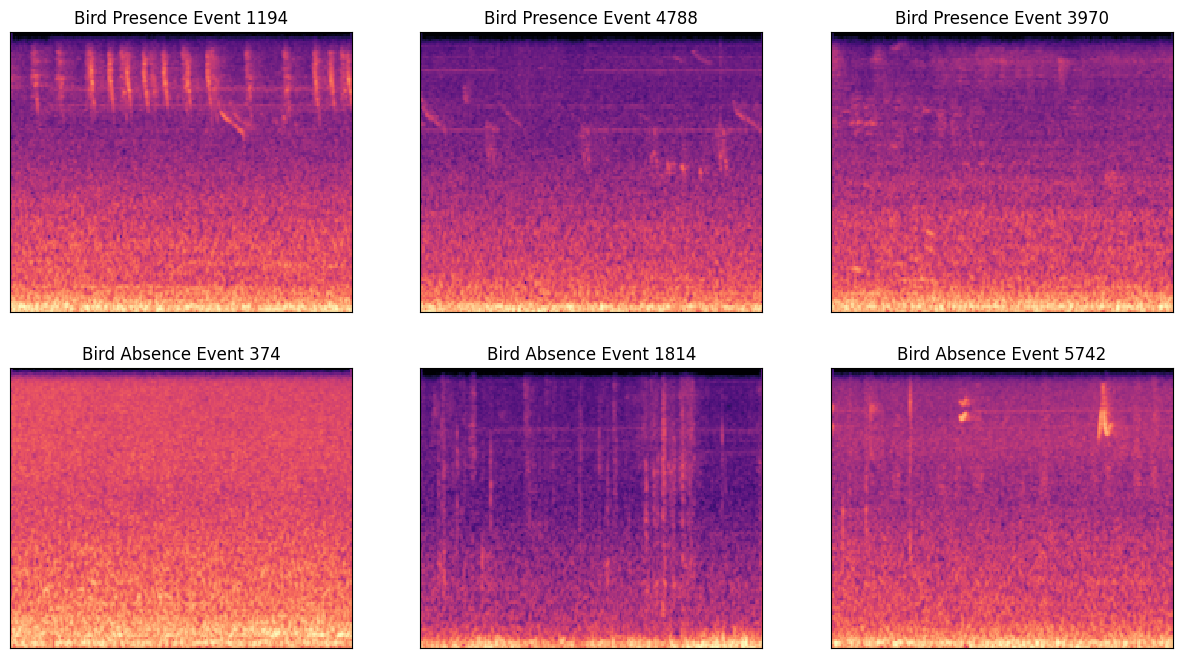

In [ ]:
plots_spectograms(X,Y)

#### Audio to spectrogram

Here is a function that will convert all of your audio segments into spectrograms, using the function written above.

In [ ]:
def convert_all_to_image(segments):
  return np.array([audio_to_spectrogram(segment) for segment in segments])

Creating all the spectrograms

In [ ]:
X_S = convert_all_to_image(X)
X_S.shape

(6497, 128, 223)

Looking how many precense and absence examples are in the training data.

In [ ]:
unique, counts = np.unique(Y, return_counts=True)
original_distribution = dict(zip(unique, counts))
print('Data distribution:', original_distribution)

Data distribution: {'0': 1379, '1': 5118}


The number of presence is very higher than the number of obsence. We will fix that later in the code by applying data augmentation

#### Data spliting into training and validation data
Here we pick 20% from the original training data as validation data.

In [ ]:
from sklearn.model_selection import train_test_split
X_train1, X_val1, y_train1, y_val1 = train_test_split(X_S, Y,
                                   random_state=seed,
                                   test_size=0.2,
                                   shuffle=True)
print(X_train1.shape)
print(y_train1.shape)
print(X_val1.shape)
print(y_val1.shape)

(5197, 128, 223)
(5197,)
(1300, 128, 223)
(1300,)


In [ ]:
del X_S, X, Y

#### Data augmentation functions
This first function `augment_one_spectrogram` receives one spectrogram (2D matrix).

It also receives the true target value for that spectrogram. The spectrogram returned from this function:
* may not be modified with 0.25 probability,
* can be adding a white noise with 0.4 probability,
* can be applying `SpecAugment` data augmentation 0.35 probability.

In [ ]:
def augment_one_spectrogram(spectrogram, true_target):
  new_spectrogram = spectrogram.copy()
  n_mels, time = new_spectrogram.shape

  p = np.random.rand()
  if p > 0.25:
    # Noise addition
    if p < 0.65:
      noise_percentage = np.random.choice([1/3, 1/2, 2/3, 1])
      if noise_percentage == 1:
        new_spectrogram += np.random.normal(scale=0.2, size=(n_mels, time))
      else:
        noise_length = int(time * noise_percentage)
        noise_start_idx = np.random.choice(range(time))
        noise_end_idx = noise_start_idx + noise_length
        if noise_end_idx <= time:
          new_spectrogram[:, noise_start_idx:noise_end_idx] += np.random.normal(scale=0.2, \
                            size=(n_mels, noise_length))
        else:
          new_spectrogram[:, noise_start_idx:] += np.random.normal(scale=0.2, \
                            size=(n_mels, time-noise_start_idx))
          new_spectrogram[:, :noise_end_idx-time] += np.random.normal(scale=0.2, \
                            size=(n_mels, noise_end_idx-time))
    # SpecAugment
    else:
      ## Apply time masking
      time_mask_length = np.random.randint(12)
      t = np.random.randint(0, time - time_mask_length)
      new_spectrogram[:, t : t + time_mask_length] = 0
      ## Apply frequency masking
      frequency_mask_width = np.random.randint(25)
      f = np.random.randint(0, n_mels - frequency_mask_width)
      new_spectrogram[f : f + frequency_mask_width, :] = 0

  return new_spectrogram, true_target

This function will randomly select one spectrogram which contains a bird call.

In [ ]:
def randomly_select_presence(all_spectrograms, targets):

  # Find all the indices where there is a bird example
  presence_indices = np.where(targets ==  positive_class)[0]

  # Randomly select index
  random_index = random.randint(0,len(presence_indices)-1)

  return all_spectrograms[presence_indices[random_index]]

This function will randomly select one spectrogram which does not contain a bird call.

In [ ]:
def randomly_select_absence(all_spectrograms, targets):

  # Find all the indices where there is a no-bird example
  absence_indices = np.where(targets == negative_class)[0]

  # Randomly select index
  random_index = random.randint(0,len(absence_indices)-1)

  return all_spectrograms[absence_indices[random_index]]

This function will generate one new spectrogram with a bird call in it.

In [ ]:
def generate_new_presence_spectrograms(all_spectrograms, all_targets, quantity):

  new_spectrograms = []
  new_targets = []

  for i in range (quantity):
    presence_spectrogram = randomly_select_presence(all_spectrograms, all_targets)
    augmented_spectrogram, augmented_target = augment_one_spectrogram(presence_spectrogram,
                                                                      positive_class)
    new_spectrograms.append(augmented_spectrogram)
    new_targets.append(augmented_target)

  return np.asarray(new_spectrograms), np.asarray(new_targets)

This function will generate one new spectrogram without a bird call in it.

In [ ]:
def generate_new_absence_spectrograms(all_spectrograms, all_targets, quantity):
  new_spectrograms = []
  new_targets = []

  for i in range (quantity):
    absence_spectrogram = randomly_select_absence(all_spectrograms, all_targets)
    augmented_spectrogram, augmented_target = augment_one_spectrogram(absence_spectrogram,
                                                                      negative_class)
    new_spectrograms.append(augmented_spectrogram)
    new_targets.append(augmented_target)

  return np.asarray(new_spectrograms), np.asarray(new_targets)

#### New training dataset

Here we will create new dataset the data augmentation algorithms written above. As ou data augmentation function `augment_one_spectrogram` can apply a modification or not, we can generate from the presence and absence targets, the same amount of data. The combination of those two dataset will be our final dataset for the training and validation.

PS: We create 2000 samples for each target.

In [ ]:
n = 2000 # number of data sample per target
X_positive, Y_positive = generate_new_presence_spectrograms(X_train1, y_train1, n)
X_negative, Y_negative = generate_new_absence_spectrograms(X_train1, y_train1, n)

# Combining them
X_train2 = np.concatenate([X_positive, X_negative])
y_train2 = np.concatenate([Y_positive, Y_negative])

# Dimension expansion to adapt it to the model input
print(X_train2.shape)
print(y_train2.shape)

(4000, 128, 223)
(4000,)


In [ ]:
del X_positive, Y_positive, X_negative, Y_negative, X_train1, y_train1

New Data visualisation

We visualise here 3 bird presence events, and 3 bird absence events chosen randomly.

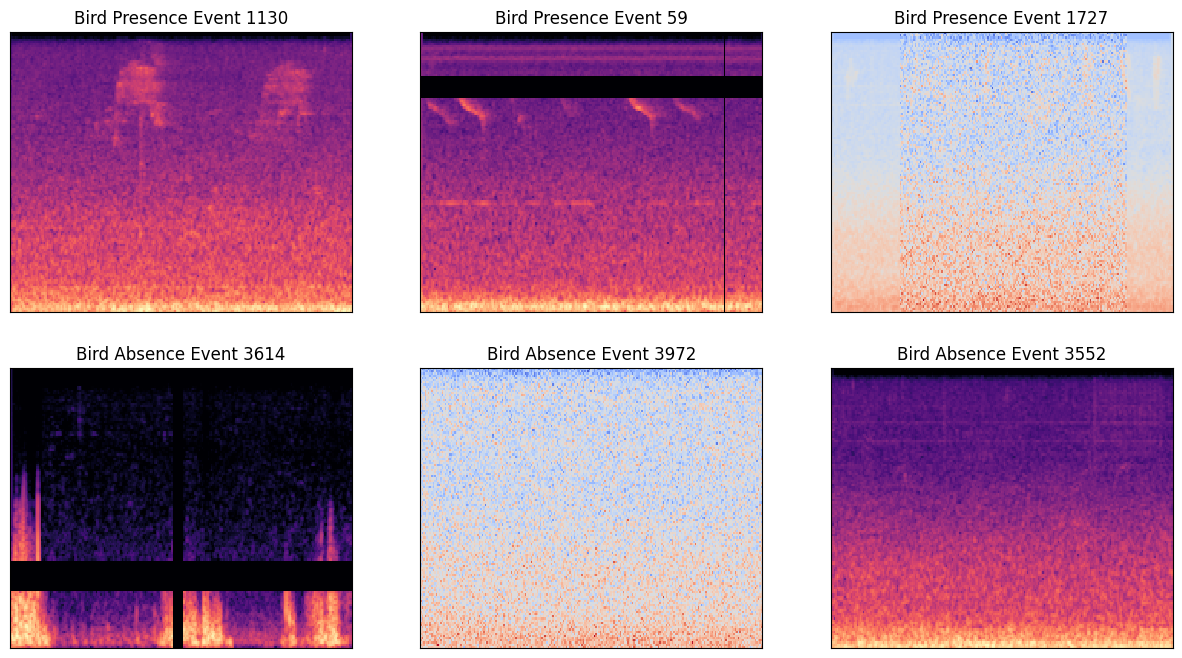

In [ ]:
plots_spectograms(X_train2, y_train2)

Some pre-processing to convert the categorical targets into one-hot encoded ones

In [ ]:
from tensorflow.keras.utils import to_categorical
# call_order = ['0','1']

# Converting categorical string labels ('0' and '1') to 0s and 1s
# for index, call_type in enumerate(call_order):
    # Y_dataset = np.where(Y_dataset == call_type, index, Y_dataset)

X_train = np.expand_dims(X_train2, axis=-1)
y_train = np.where(y_train2 == positive_class, 1, 0)
y_train = to_categorical(y_train, num_classes = 2)

X_val = np.expand_dims(X_val1, axis=-1)
y_val = np.where(y_val1 == positive_class, 1, 0)
y_val = to_categorical(y_val, num_classes = 2)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(4000, 128, 223, 1)
(4000, 2)
(1300, 128, 223, 1)
(1300, 2)


In [ ]:
del X_train2, y_train2, X_val1, y_val1

## Step 2: Model training and testing

### Model training
We implement here a 2D *CNN*

In [ ]:
from tensorflow.keras import backend#, Input, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, MaxPool2D, Conv2D, BatchNormalization
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint

# Initialisation
INPUT_SHAPE = X_train.shape[1:]

# Starting point
model = Sequential([
  Conv2D(filters = 16, kernel_size = 4, input_shape = INPUT_SHAPE, activation = 'relu', padding='same'),
  MaxPool2D(pool_size = 3),
  BatchNormalization(),
  Dropout(0.5),
  Conv2D(filters = 32, kernel_size = 4, activation = 'relu', padding='same'),
  MaxPool2D(pool_size=3),
  BatchNormalization(),
  Dropout(0.5),
  Conv2D(filters = 64, kernel_size = 4, activation = 'relu', padding='same'),
  MaxPool2D(pool_size=3),
  BatchNormalization(),
  Flatten(),
  Dense(units = 512, activation='relu'),
  BatchNormalization(),
  Dropout(0.5),
  Dense(units = 64, activation='relu'),
  BatchNormalization(),
  Dense(2, activation = 'softmax')
])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 223, 16)      272       
                                                                 
 max_pooling2d (MaxPooling2  (None, 42, 74, 16)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 42, 74, 16)        64        
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 42, 74, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 74, 32)        8224      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 24, 32)        0

In [ ]:
EPOCHS = 10
checkpoint_filepath = 'best.model.keras'
model_checkpoint_callback = ModelCheckpoint(
  filepath=checkpoint_filepath,
  monitor='val_accuracy',
  mode='max',
  save_best_only=True, verbose=1)

Train the model

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Model is saved at the end of every epoch, if it's the best seen so far.
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=EPOCHS,
                    callbacks=[model_checkpoint_callback],
                    batch_size=32)

Epoch 1/10
125/125 [==============================] - ETA: 0s - loss: 0.7402 - accuracy: 0.5403
Epoch 1: val_accuracy improved from -inf to 0.78538, saving model to best.model.keras
125/125 [==============================] - 81s 632ms/step - loss: 0.7402 - accuracy: 0.5403 - val_loss: 0.5253 - val_accuracy: 0.7854
Epoch 2/10
125/125 [==============================] - ETA: 0s - loss: 0.6704 - accuracy: 0.5960
Epoch 2: val_accuracy did not improve from 0.78538
125/125 [==============================] - 81s 645ms/step - loss: 0.6704 - accuracy: 0.5960 - val_loss: 1.1176 - val_accuracy: 0.7854
Epoch 3/10
125/125 [==============================] - ETA: 0s - loss: 0.6170 - accuracy: 0.6480
Epoch 3: val_accuracy did not improve from 0.78538
125/125 [==============================] - 83s 663ms/step - loss: 0.6170 - accuracy: 0.6480 - val_loss: 0.7296 - val_accuracy: 0.7854
Epoch 4/10
125/125 [==============================] - ETA: 0s - loss: 0.5705 - accuracy: 0.6990
Epoch 4: val_accuracy did 

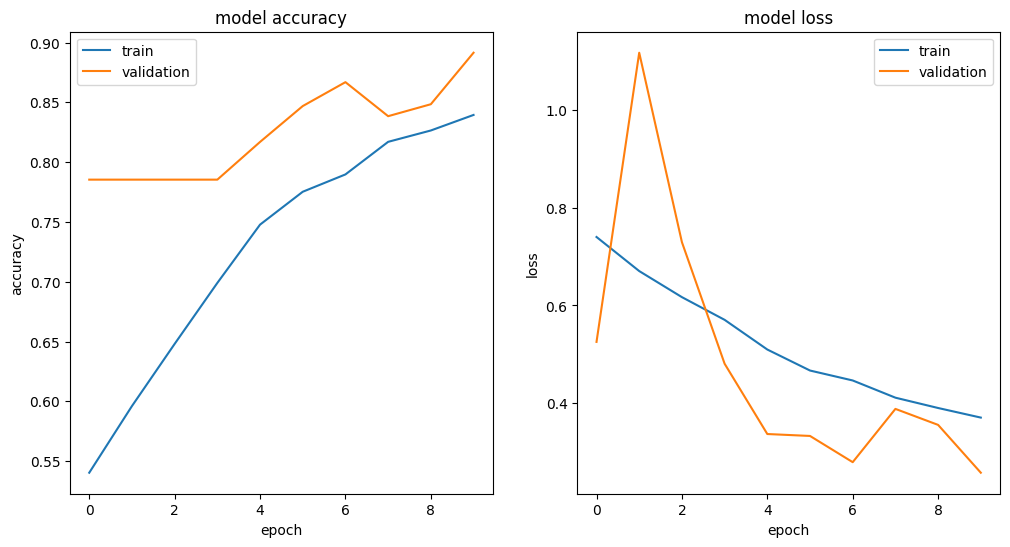

In [40]:
fig, axes = plt.subplots(1,2, figsize=(12,6))
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'validation'])
# summarize history for loss
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('model loss')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].legend(['train', 'validation'])
plt.show()

### Model Testing

Below we applied the same preprocessing we have applied to the training data


#### Prediction function
The function below will predict on the preprocessed test data and return the array of the prediction filled with 1 and 0 indicating the presence or absence of bird vocalisation.

In [ ]:
def get_prediction(X:np.ndarray, **kwargs) -> np.ndarray:
  backend.clear_session()
  model = load_model(checkpoint_filepath)
  y_pred = model.predict(X, **kwargs)
  return np.argmax(y_pred, axis=-1)

#### Confusion matrix function
This function allows to evaluate how much the model performs

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True, normalize_by="row",
                          ax=None, title="Confusion matrix",
                          cmap="jet", precision=2,
                         ):

    y_true=y_true.astype(int)
    y_pred=y_pred.astype(int)

    np.set_printoptions(precision=precision)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Only use the labels that appear in the data
    # print("Confusion matrix, without normalization:")
    # print(cm)

    if normalize:
      if normalize_by=="col" :
        cm = cm.astype('float') / cm.sum(axis=0)[np.newaxis, :]
      elif normalize_by=="row":
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix")
        # print(cm)

    if not ax:
      fig, ax = plt.subplots(figsize=(6,6))
    ax.grid(False)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.'+str(precision)+'f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "coral")
    fig.tight_layout()

#### Test data preprocessing
We have modified the preprocessing function to allows preprocessing the training data which names are in `TrainingFiles.txt` as well as the testing one in `TestingFiles.txt` both located in  `DataFiles`.

In [36]:
# This takes about 1 minute [ 0 marks]
pre_pro = Preprocessing(species_folder, lowpass_cutoff,
                downsample_rate, nyquist_rate,
                segment_duration,
                [positive_class], [negative_class],n_fft,
                hop_length, n_mels, f_min, f_max, file_type,
                audio_extension, data_type = 'test')

X, Y = pre_pro.create_dataset(False)

Processing: 21_3-2-2024=7_19_54
Found file
Filtering...
Downsampling...
21_3-2-2024=7_19_54
Reading annotations...
Processing: 23_2-2-2024=20_39_19
Found file
Filtering...
Downsampling...
23_2-2-2024=20_39_19
Reading annotations...
Processing: 19_19_fermat_12
Found file
Filtering...
Downsampling...
19_19_fermat_12
Reading annotations...
Processing: 17_20240203_081105
Processing: 23_2-2-2024=20_42_49
Found file
Filtering...
Downsampling...
23_2-2-2024=20_42_49
Reading annotations...
Processing: 20_r23_dariose
Found file
Filtering...
Downsampling...
20_r23_dariose
Reading annotations...
Processing: 3_2-2-2024=22_1_6
Found file
Filtering...
Downsampling...
3_2-2-2024=22_1_6
Reading annotations...
Processing: 24_2
Found file
Filtering...
Downsampling...
24_2
Reading annotations...
Processing: 18_3-2-2024=6_55_2
Found file
Filtering...
Downsampling...
18_3-2-2024=6_55_2
Reading annotations...
Processing: 9_2-2-2024=21_2_1
Found file
Filtering...
Downsampling...
9_2-2-2024=21_2_1
Reading ann

In [37]:
X_test = np.expand_dims(convert_all_to_image(X), axis=-1)
Y = Y.astype(int)
print(X.shape)
print(Y.shape)

(2123, 57000)
(2123,)


In [ ]:
del X#, X_dataset, Y_dataset

#### Prediction

In [ ]:
y_pred = get_prediction(X_test)

67/67 [==============================] - 11s 167ms/step


Confusion matrix ploting

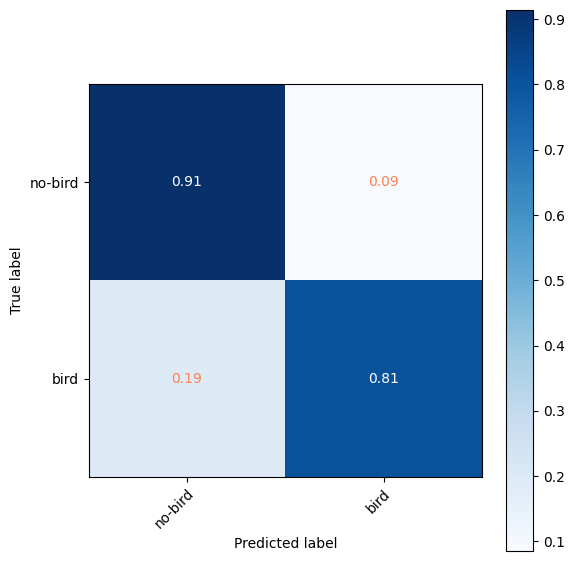

In [ ]:
plot_confusion_matrix(Y, y_pred, ['no-bird', 'bird'], cmap='Blues', normalize=True)

#### Accuracy

In [ ]:
tp = np.equal(Y, y_pred)
acc = sum(tp) / len(tp)
print(f"The model accuracy on test data si {acc*100:.4}%.")

The model accuracy on test data si 83.23%.
